In [98]:
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")
library(tidyverse)
library(repr)
options(repr.plot.width=8, repr.plot.height=5.5)

library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
#devtools::install_local('../../PtDAlgorithms', quiet=FALSE)
library(ptdalgorithms)

source("plot_functions.R")

theme_set(theme_bw())
despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(size=17, 
                                  # family="Arial"
                                 )
                ) 

# R version of add_epoque

In [100]:
epoque_coalescent <- function(n, size, graph=NULL, edge_trans=NULL, epoque=0) {

    state_vector_length <- n + 1

    if (is.null(graph)) {
    
        graph <- create_graph(state_vector_length)
        starting_vertex <- vertex_at(graph, 1)
        initial_state <- c(rep(0, n), epoque)
        initial_state[1] <- n
        
        add_edge(
          starting_vertex,
          create_vertex(graph, initial_state),
          1
        )
        index <- 2
        
    } else {
        nr_states <- vertices_length(graph)
        for (i in 2:(nr_states-1)) {
            if (is.nan(edge_trans[i-1])) {
                next;
            }
            vertex <- vertex_at(graph, i)
            state <- vertex$state
            sister_state <- state
            sister_state[length(sister_state)] <- epoque
            add_edge(
              vertex,
              find_or_create_vertex(graph, sister_state),
              edge_trans[i-1], c(edge_trans[i-1]) # -1 becuase first index is 2 and first element of edge_trans is 1
            )
        }
        index <- nr_states + 1
    }

    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)

        # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state

          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next; # an absorbing state that is not the last state
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }

          rate = rate / size
            
          # copy state
          child_state <- state
            
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }
        
      index <- index + 1
    }
    if (epoque == 0) {
        return(graph)
    }
}

r_add_epoque <- function(n, size, graph, epoque_trans, epoque)
    return(epoque_coalescent(n, size, graph, epoque_trans, epoque))

## Check that I get the same as Janek for n=10

In [101]:
janek <- c(8.807791589074768, 177.8449395799212, 5388.12207361224, 216313.46645481227, 10829024.877199283)

In [102]:
epoques <- c(0, 1, 2)
pop_sizes <- c(1, 5, 10)
n_samples <- 10

In [103]:
graph <- epoque_coalescent(n_samples, pop_sizes[1])
moments(graph, 5)

[1]   1.800000   4.398142  14.172264  58.136567 293.229090

In [104]:
x <- stop_probability(graph, epoques[2])
stop_probs <- x[2:(length(x)-1)]
x <- accumulated_visiting_time(graph, epoques[2])
accum_v_time <- x[2:(length(x)-1)]
epoque_trans_rates <- stop_probs / accum_v_time
r_add_epoque(n_samples, pop_sizes[2], graph, epoque_trans_rates, 2)
moments(graph, 5)

[1] 5.231394e+00 5.312374e+01 8.052343e+02 1.617477e+04 4.049925e+05

In [105]:
x <- stop_probability(graph, epoques[3])
stop_probs <- x[2:(length(x)-1)]
x <- accumulated_visiting_time(graph, epoques[3])
accum_v_time <- x[2:(length(x)-1)]
epoque_trans_rates <- stop_probs / accum_v_time
r_add_epoque(n_samples, pop_sizes[3], graph, epoque_trans_rates, 3)
moments(graph, 5)

[1] 8.823843e+00 1.757199e+02 5.304456e+03 2.127639e+05 1.064856e+07

In [106]:
mine <- moments(graph, 5)
mine

[1] 8.823843e+00 1.757199e+02 5.304456e+03 2.127639e+05 1.064856e+07

In [107]:
janek

[1] 8.807792e+00 1.778449e+02 5.388122e+03 2.163135e+05 1.082902e+07

In [108]:
(mine - janek) / janek

[1]  0.001822437 -0.011948873 -0.015527948 -0.016409474 -0.016665343

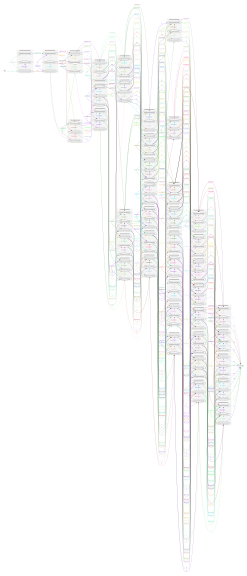

In [109]:
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

In [110]:
moments(graph, 5)

[1] 8.823843e+00 1.757199e+02 5.304456e+03 2.127639e+05 1.064856e+07

### SFS

In [111]:
# rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
state_mat <- states(graph)
rewards <- state_mat[, -ncol(state_mat)] # remove columns with epoque labels

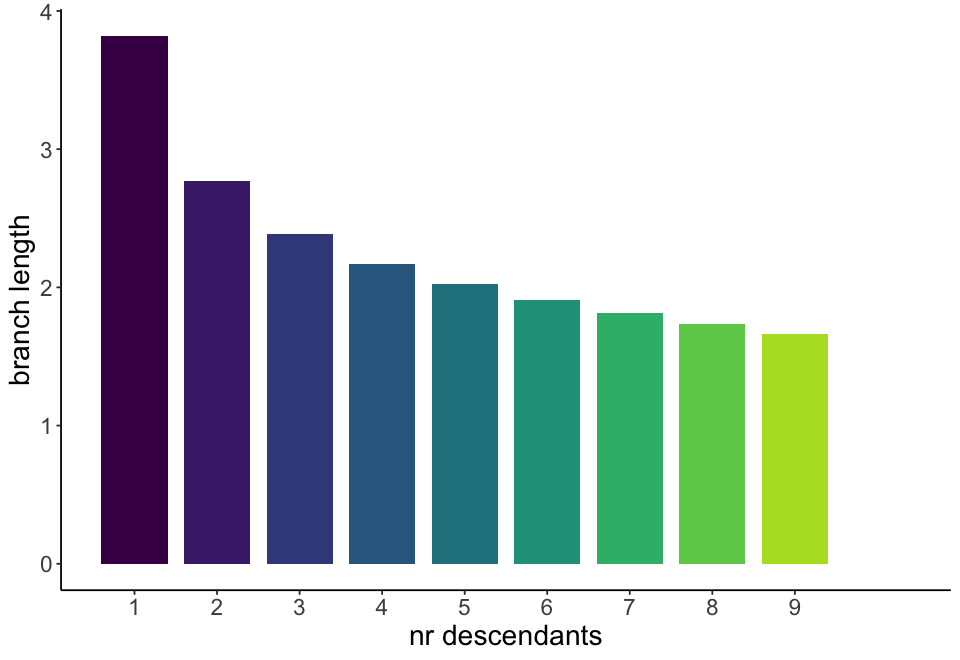

In [112]:
plot_sfs(graph, rewards) + labs(y = "branch length", x = "ton") +  
                  scale_x_continuous(breaks = 1:9)+ theme(legend.position = "none") + labs(x='nr descendants')

### SFS using dist context

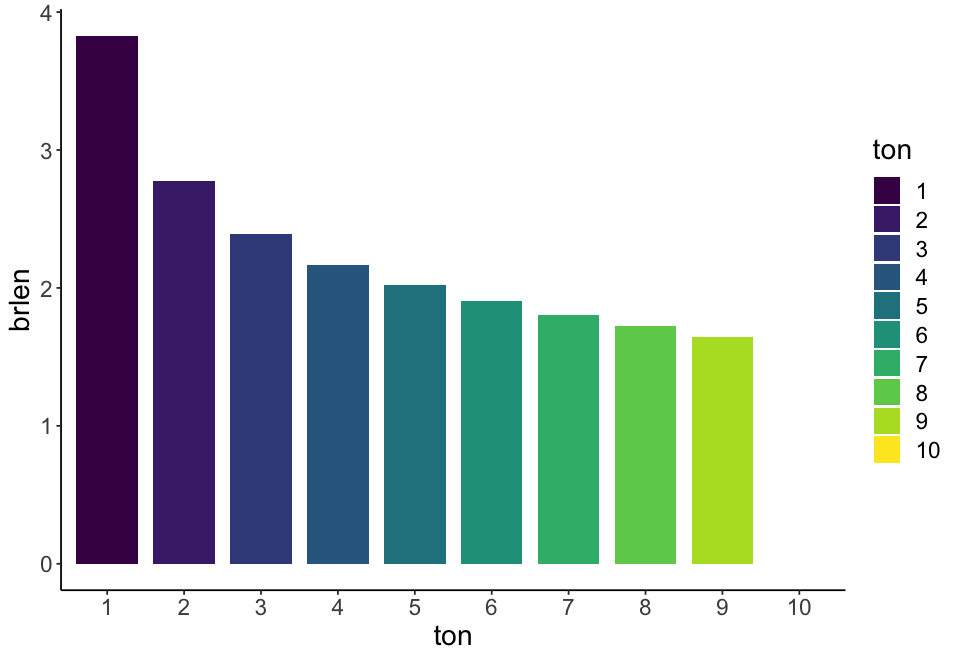

In [113]:
distr_cont_graph <- epoque_coalescent(n_samples, pop_sizes[1])
rewards <- sapply(1:vertices_length(distr_cont_graph), function(index) vertex_at(distr_cont_graph, index)$state )

tmrca_pdf <- c()
time <- c()

#ctx <- distribution_context(distr_cont_graph, 1000)
ctx <- distribution_context(distr_cont_graph)
prev_size <- 0
while (distribution_context_state(ctx)$cdf < 0.999) { 
    tmrca_pdf[[(length(tmrca_pdf) + 1)]] <- distribution_context_state(ctx)$pdf
    time[[(length(time) + 1)]] <- distribution_context_state(ctx)$time
    
    size <- pop_sizes[findInterval(distribution_context_state(ctx)$time, epoques)]
    if (size != prev_size) {
        graph_update_weights_parameterized(distr_cont_graph, c(1/size))
    }
    prev_size <- size
    distribution_context_step(ctx)
}
expected_visits <- distribution_context_accumulated_visiting_time(ctx)
sfs <- c()
for (i in 1:(dim(rewards)[1]-1)) {
    sfs <- c(sfs, sum(expected_visits * rewards[i, ]))
}
data.frame(ton=as.factor(seq(1,length(sfs))), 
           brlen=sfs) %>%
ggplot(aes(x=ton, y=brlen, fill=ton)) + 
  geom_bar(stat = "identity", width=0.8) + 
                  scale_fill_viridis(discrete=TRUE) + 
                  despine

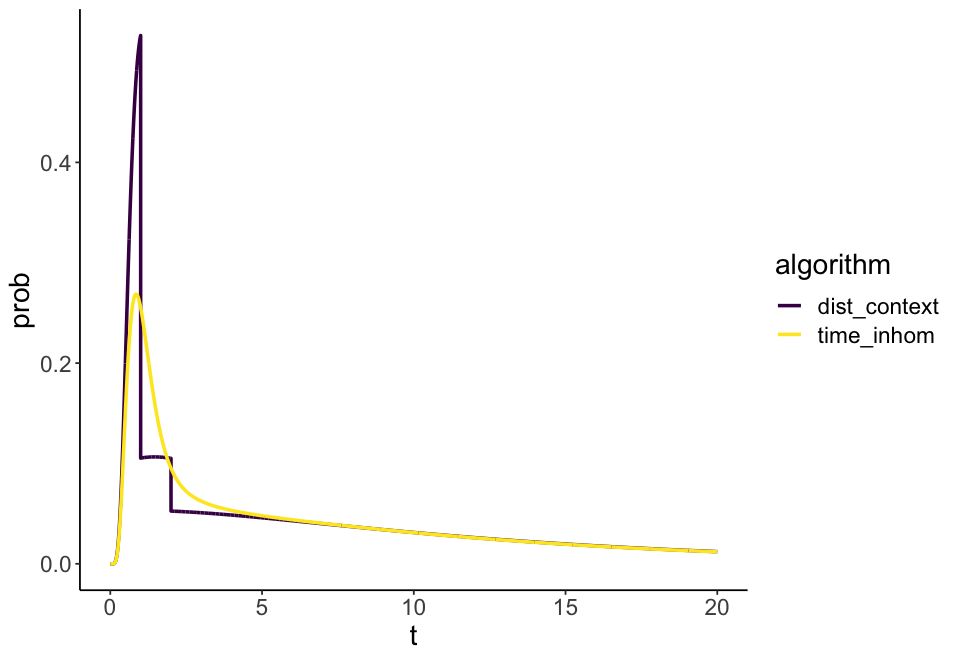

In [114]:
df <- data.frame(prob = unlist(tmrca_pdf), t=unlist(time), algorithm='dist_context')
x <- seq(from = 0, to = max(df$t), by = 0.01)
plot_df <- rbind(df, data.frame(prob = dph(x, graph), t=x, algorithm='time_inhom'))
options(warn=-1)
    ggplot(plot_df, aes(y=prob, x=t, color=algorithm, style=algorithm)) + 
        geom_line(linewidth=1) + 
        scale_color_viridis_d() + 
        despine + xlim(0, 20)
options(warn=0)

## Sample size nr_samples

In [117]:
epoques <- c(0, 1, 2)
pop_sizes <- c(1, 5, 10)
n_samples <- 2

### Epoque 1

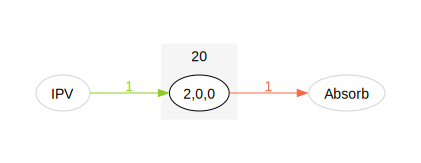

[1]   1   2   6  24 120

In [118]:
graph <- epoque_coalescent(n_samples, pop_sizes[1])
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))
moments(graph, 5)

### Epoque 2

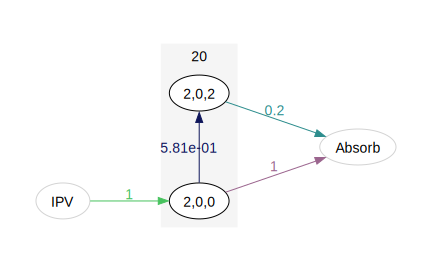

[1] 2.470271e+00 2.150295e+01 3.164733e+02 6.314108e+03 1.578041e+05

In [119]:
x <- stop_probability(graph, epoques[2])
stop_probs <- x[2:(length(x)-1)]
x <- accumulated_visiting_time(graph, epoques[2])
accum_v_time <- x[2:(length(x)-1)]
epoque_trans_rates <- stop_probs / accum_v_time
# epoque_trans_rates[which(accum_v_time == 0)] <- 0
#epoque_trans_rates
r_add_epoque(n_samples, pop_sizes[2], graph, epoque_trans_rates, 2)
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))
moments(graph, 5)           

### Epoque 3

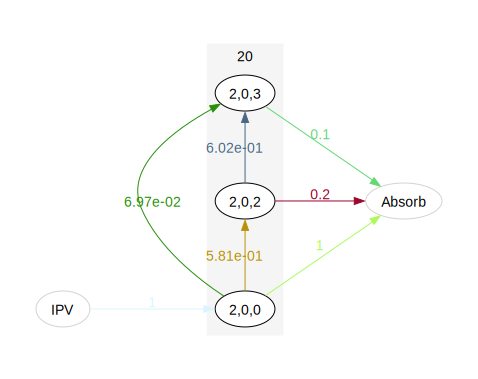

[1] 4.109414e+00 7.395721e+01 2.199663e+03 8.791993e+04 4.395667e+06

In [120]:
x <- stop_probability(graph, epoques[3])
stop_probs <- x[2:(length(x)-1)]
x <- accumulated_visiting_time(graph, epoques[3])
accum_v_time <- x[2:(length(x)-1)]
epoque_trans_rates <- stop_probs / accum_v_time
# epoque_trans_rates[which(accum_v_time == 0)] <- 0
#epoque_trans_rates
r_add_epoque(n_samples, pop_sizes[3], graph, epoque_trans_rates, 3)
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))
moments(graph, 5)

In [85]:
gam

$states
     [,1] [,2] [,3] [,4]
[1,]    3    0    0    0
[2,]    1    1    0    0
[3,]    3    0    0    2
[4,]    1    1    0    2
[5,]    3    0    0    3
[6,]    1    1    0    3

$SIM
          [,1]      [,2]       [,3]       [,4]         [,5]        [,6]
[1,] -3.162113  3.000000  0.1564366  0.0000000  0.005676686  0.00000000
[2,]  0.000000 -2.100925  0.0000000  1.0073813  0.000000000  0.09354392
[3,]  0.000000  0.000000 -0.9525654  0.6000000  0.352565381  0.00000000
[4,]  0.000000  0.000000  0.0000000 -0.9171685  0.000000000  0.71716848
[5,]  0.000000  0.000000  0.0000000  0.0000000 -0.300000000  0.30000000
[6,]  0.000000  0.000000  0.0000000  0.0000000  0.000000000 -0.10000000

$IPV
[1] 1 0 0 0 0 0

$indices
[1] 2 3 5 6 8 9

# C++ version of add_epoque

**TODO:**

**For now I assume there is an empty slot at the end of the state vector that can be used to label epoque. It would be better if add_epoque somehow added a state slot at the end to the state vector and then put a 1 in that. That way the state vector would grow by one for each added epoque and the those extra slots would have 0 or 1 in them.**

In [86]:
#library(plotly)
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")

library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")

#remove.packages("ptdalgorithms")
# devtools::install_github("munch-group/PtDAlgorithms")
devtools::install_local('../../PtDAlgorithms', quiet=FALSE, force = TRUE)


── R CMD build ─────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/private/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/Rtmpr4SAtR/file53e64dc08603/PtDAlgorithms/DESCRIPTION’ (424ms)
─  preparing ‘ptdalgorithms’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
   Omitted ‘LazyData’ from DESCRIPTION
─  building ‘ptdalgorithms_1.0.0.tar.gz’
   


In [87]:
standard_coalescent <- function(n) {
          
    state_vector_length <- n + 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(rep(0, n), 0)
    initial_state[1] <- n
    
    add_edge(
      starting_vertex,
      find_or_create_vertex(graph, initial_state),
      1
    )
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      
      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state
          
          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }
          
          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }
          
      index <- index + 1
    }
    return(graph)
}
# graph <- standard_coalescent(4)
# graph_update_weights_parameterized(graph, c(1))
# graph_as_matrix(graph)

In [88]:
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")

library(tidyverse)
library(devtools)
library(ptdalgorithms)

source("plot_functions.R")

theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(family="Arial")
                )

## This works

In [92]:
Rcpp::sourceCpp("./cpp/add_epoque.cpp")

add_epoques_to_graph <- function(graph, epoque_params, times) {
    
  for (i in seq_len(nrow(epoque_params))) {
    add_epoque(graph, epoque_params[i,], times[i])
  }
    
  gam <- graph_as_matrix(graph)
  graph <- matrix_as_graph(gam$IPV, gam$SIM, gam$states)
    
  return(graph)
}


# pop_sizes <- c(5, 10)
# mig_rates <- c(1, 1)
# epoque_params <- cbind(1/pop_sizes, mig_rates)

epoque_params <- matrix(c(1/5, 1/10))
times <- c(1, 2)

graph <- standard_coalescent(10)
graph <- add_epoques_to_graph(graph, epoque_params, times)

moments(graph, 5)

[1] 8.823843e+00 1.757199e+02 5.304456e+03 2.127639e+05 1.064856e+07

## This is why

This shows the reason why we need to do the to-matrix-and-back trick after adding all the epoques (and only then):

In [93]:
Rcpp::sourceCpp("./cpp/add_epoque.cpp")
graph <- standard_coalescent(4)
add_epoque(graph, c(1/5), 1)
add_epoque(graph, c(1/10), 2)

Using the moments function on the resulting graph does not work:

In [94]:
moments(graph, 5)

[1]   1.489017   3.434245  11.155280  47.484073 251.195792

However, it works if you convert it to matrices compute the moments manually:

In [95]:
gam <- graph_as_matrix(graph)
nr_states <- nrow(gam$states)
U <- -solve(gam$SIM)
r <- diag(x = rep(1, nr_states), nr_states, nr_states)
ipv <- gam$IPV
e <- rep(1, nr_states)
c(ipv %*% U %*% r %*% e)

[1] 6.817888

and if you turn the matrix back into a graph and use the moments function:

In [96]:
mat_graph <- matrix_as_graph(gam$IPV, gam$SIM, gam$states)
moments(mat_graph, 5)

[1] 6.817888e+00 1.302973e+02 3.905602e+03 1.563672e+05 7.821490e+06

... **but** if you do the to-matrix-and-back trick after every added epoque it does **not** work:

In [97]:
Rcpp::sourceCpp("./cpp/add_epoque.cpp")
graph <- standard_coalescent(10)
add_epoque(graph, c(1/5), 1)
gam <- graph_as_matrix(graph)
graph <- matrix_as_graph(gam$IPV, gam$SIM, gam$states)
add_epoque(graph, c(1/10), 2)
gam <- graph_as_matrix(graph)
graph <- matrix_as_graph(gam$IPV, gam$SIM, gam$states)
moments(graph, 5)

[1]    2.421759    8.108697   34.722829  180.716760 1106.839562

**So**, to make it work, I need to add the all the epoques and only then do the to-matrix-and-back trick ....